In [1]:
import os

os.environ["LD_LIBRARY_PATH"] = ":/home/ztan/.mujoco/mujoco200/bin"
os.environ.get("LD_LIBRARY_PATH", "")
from gym.envs.mujoco import HalfCheetahEnv
from gym.envs.box2d import CarRacing

import rlkit.torch.pytorch_util as ptu
from rlkit.data_management.env_replay_buffer import EnvReplayBuffer
from rlkit.envs.wrappers import NormalizedBoxEnv
from rlkit.launchers.launcher_util import setup_logger
from rlkit.samplers.data_collector import MdpPathCollector
from rlkit.torch.sac.policies import (
    TanhGaussianPolicy,
    MakeDeterministic,
    TanhCNNGaussianPolicy,
    GaussianCNNPolicy,
)
from rlkit.torch.sac.sac import SACTrainer
from rlkit.torch.networks import ConcatMlp, PretrainedCNN, CNN
from rlkit.torch.torch_rl_algorithm import TorchBatchRLAlgorithm

import torch
import torchvision.models as models

from absl import app, flags
from typing import Sequence
import sys
from absl import app
from dm_control import viewer
from dm_robotics.moma import action_spaces


import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

import dmc2gym
from gym import core, spaces
from dm_control import suite
from dm_env import specs
import numpy as np
from rgb_stacking import environment

No personal conf_private.py found.
doodad not detected


In [2]:
action = action = np.array([0, 0, 0, 0, 0], dtype=np.float32)
env = environment.rgb_stacking(observation_set=environment.ObservationSet.ALL, object_triplet='rgb_test_triplet5')
o = env.reset()
# ptu.set_gpu_mode(True)

Failed to establish dbus connection

In [3]:
env_wrapped = dmc2gym.make(domain_name="rgb_stacking_state_only", task_name='rgb_test_triplet1')

self._using_rgb_stacking (STATE_ONLY)


In [8]:
env_wrapped.action_space.sample()

array([ 0.61478084,  0.02900014, -0.6177637 , -0.62625045,  0.5450433 ],
      dtype=float32)

In [ ]:
env.observation_spec()['basket_front_left/pixels']

In [ ]:
from dm_env import specs
specs.Array(shape=(64, 128, 3), dtype='uint8', name='images').name

In [ ]:
# boxes = env.observation_spec()
boxes = [specs.Array(shape=(64, 128, 3), dtype='uint8', name='images')]
for i in env.observation_spec().values():
    if "basket" not in i.name:
        boxes.append(i)
            
def _spec_to_box(spec):
    def extract_min_max(s):
        # assert s.dtype == np.float64 or s.dtype == np.float32
        dim = np.int(np.prod(s.shape))
        if type(s) == specs.Array:
            bound = np.inf * np.ones(dim, dtype=np.float32)
            return -bound, bound
        elif type(s) == specs.BoundedArray:
            zeros = np.zeros(dim, dtype=np.float32)
            return s.minimum + zeros, s.maximum + zeros

    mins, maxs = [], []
    for s in spec:
        mn, mx = extract_min_max(s)
        mins.append(mn)
        maxs.append(mx)
    low = np.concatenate(mins, axis=0)
    high = np.concatenate(maxs, axis=0)
    assert low.shape == high.shape
    return spaces.Box(low, high, dtype=np.float32)
_spec_to_box(boxes)

In [ ]:
sum([v.ravel().shape[0] for k,v in out.observation.items()])

In [ ]:
def _flatten_obs(obs):
    obs_pieces = []
    for v in obs.values():
        flat = np.array([v]) if np.isscalar(v) else v.ravel()
        obs_pieces.append(flat)
    return np.concatenate(obs_pieces, axis=0)

_flatten_obs(out.observation)

In [ ]:
out = env.step(action)
# states are stacked
left = out.observation.pop('basket_front_left/pixels')
right = out.observation.pop('basket_front_right/pixels')

img = np.concatenate([left, right], axis=1).ravel()
# rest = _flatten_obs({})
# for k,v in out.observation.items():
#     print(v.ravel().shape)

In [ ]:
def _flatten_obs(obs):
    obs_pieces = []
    for v in obs.values():
        flat = np.array([v]) if np.isscalar(v) else v.ravel()
        obs_pieces.append(flat)
    return np.concatenate(obs_pieces, axis=0)



In [ ]:
env_vis = environment.rgb_stacking(observation_set=environment.ObservationSet.STATE_ONLY, object_triplet='rgb_test_triplet1')
env_vis.reset()


In [ ]:
# from dm_env import specs
# def _spec_to_box(spec):
#     def extract_min_max(s):
#         # assert s.dtype == np.float64 or s.dtype == np.float32
#         dim = np.int(np.prod(s.shape))
#         if type(s) == specs.Array:
#             bound = np.inf * np.ones(dim, dtype=np.float32)
#             return -bound, bound
#         elif type(s) == specs.BoundedArray:
#             zeros = np.zeros(dim, dtype=np.float32)
#             return s.minimum + zeros, s.maximum + zeros

#     mins, maxs = [], []
#     for s in spec:
#         mn, mx = extract_min_max(s)
#         mins.append(mn)
#         maxs.append(mx)
#     low = np.concatenate(mins, axis=0)
#     high = np.concatenate(maxs, axis=0)
#     assert low.shape == high.shape
#     return spaces.Box(low, high, dtype=np.float32)
# expl_env = NormalizedBoxEnv(CarRacing())
# obs_dim = expl_env.observation_space.low.size
# action_dim = expl_env.action_space.low.size
# obs_dim, action_dim # yes we flatten anyways
# action = action = np.array([0, 0, 0, 0, 0], dtype=np.float32)



In [14]:

, 

(1.671763793626269, 0.0006655165691711)

<AxesSubplot:xlabel='Train Steps (x 800)', ylabel='Average Return'>

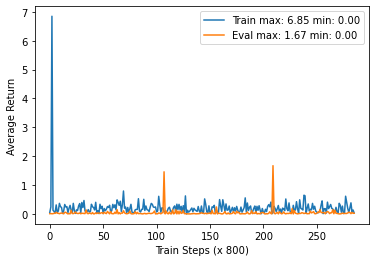

In [31]:
import pandas as pd
df_visual = pd.read_csv("data/rgb-stacking-with-states/rgb_stacking_with_states_2021_11_18_22_01_14_0000--s-0/progress.csv")
df_visual['expl/Average Returns'].plot(xlabel='Train Steps (x 800)', ylabel="Average Return", legend="Train", label=f"Train max: {df_visual['expl/Average Returns'].max():.2f} min: {df_visual['expl/Average Returns'].min():.2f}")
df_visual['eval/Average Returns'].plot(xlabel='Train Steps (x 800)', ylabel="Average Return", legend="Eval", label=f"Eval max: {df_visual['eval/Average Returns'].max():.2f} min: {df_visual['eval/Average Returns'].min():.2f}")

<AxesSubplot:xlabel='Train Steps (x 800)', ylabel='Average Return'>

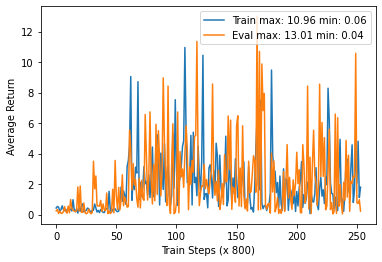

In [18]:
import pandas as pd
df = pd.read_csv("data/rgb-stacking-states-only/rgb_stacking_states_only_2021_11_19_19_29_02_0000--s-0/progress.csv")
df['expl/Average Returns'].plot(xlabel='Train Steps (x 800)', ylabel="Average Return", legend="Train", label=f"Train max: {df['expl/Average Returns'].max():.2f} min: {df['expl/Average Returns'].min():.2f}")
df['eval/Average Returns'].plot(xlabel='Train Steps (x 800)', ylabel="Average Return", legend="Eval", label=f"Eval max: {df['eval/Average Returns'].max():.2f} min: {df['eval/Average Returns'].min():.2f}")

In [17]:
(4304552036 - 4294937296)/250/60/60

10.683044444444445

In [ ]:
action = action = np.array([0, 0, 0, 0, 0], dtype=np.float32)
env = dmc2gym.make(domain_name="rgb_stacking", task_name='rgb_test_triplet1')
o = env.reset()

In [ ]:
out = env.step(action)

In [ ]:
import cv2
img = out[0][:128*64*3].reshape((64, 128, 3))
%matplotlib inline 
from matplotlib import pyplot as plt
# plt.imshow(img)
plt.imshow(img)
plt.show()

In [ ]:
raise ValueError

In [ ]:
import timm
from pprint import pprint
model_names = timm.list_models('')
print(model_names)

In [ ]:
model_names = [
    "adv_inception_v3",
    "bat_resnext26ts",
    "beit_base_patch16_224",
    "beit_base_patch16_224_in22k",
    "beit_base_patch16_384",
    "beit_large_patch16_224",
    "beit_large_patch16_224_in22k",
    "beit_large_patch16_384",
    "beit_large_patch16_512",
    "botnet26t_256",
    "botnet50ts_256",
    "cait_m36_384",
    "cait_m48_448",
    "cait_s24_224",
    "cait_s24_384",
    "cait_s36_384",
    "cait_xs24_384",
    "cait_xxs24_224",
    "cait_xxs24_384",
    "cait_xxs36_224",
    "cait_xxs36_384",
    "coat_lite_mini",
    "coat_lite_small",
    "coat_lite_tiny",
    "coat_mini",
    "coat_tiny",
    "convit_base",
    "convit_small",
    "convit_tiny",
    "convmixer_768_32",
    "convmixer_1024_20_ks9_p14",
    "convmixer_1536_20",
    "crossvit_9_240",
    "crossvit_9_dagger_240",
    "crossvit_15_240",
    "crossvit_15_dagger_240",
    "crossvit_15_dagger_408",
    "crossvit_18_240",
    "crossvit_18_dagger_240",
    "crossvit_18_dagger_408",
    "crossvit_base_240",
    "crossvit_small_240",
    "crossvit_tiny_240",
    "cspdarknet53",
    "cspdarknet53_iabn",
    "cspresnet50",
    "cspresnet50d",
    "cspresnet50w",
    "cspresnext50",
    "cspresnext50_iabn",
    "darknet53",
    "deit_base_distilled_patch16_224",
    "deit_base_distilled_patch16_384",
    "deit_base_patch16_224",
    "deit_base_patch16_384",
    "deit_small_distilled_patch16_224",
    "deit_small_patch16_224",
    "deit_tiny_distilled_patch16_224",
    "deit_tiny_patch16_224",
    "densenet121",
    "densenet121d",
    "densenet161",
    "densenet169",
    "densenet201",
    "densenet264",
    "densenet264d_iabn",
    "densenetblur121d",
    "dla34",
    "dla46_c",
    "dla46x_c",
    "dla60",
    "dla60_res2net",
    "dla60_res2next",
    "dla60x",
    "dla60x_c",
    "dla102",
    "dla102x",
    "dla102x2",
    "dla169",
    "dm_nfnet_f0",
    "dm_nfnet_f1",
    "dm_nfnet_f2",
    "dm_nfnet_f3",
    "dm_nfnet_f4",
    "dm_nfnet_f5",
    "dm_nfnet_f6",
    "dpn68",
    "dpn68b",
    "dpn92",
    "dpn98",
    "dpn107",
    "dpn131",
    "eca_botnext26ts_256",
    "eca_halonext26ts",
    "eca_nfnet_l0",
    "eca_nfnet_l1",
    "eca_nfnet_l2",
    "eca_nfnet_l3",
    "eca_resnet33ts",
    "eca_resnext26ts",
    "eca_vovnet39b",
    "ecaresnet26t",
    "ecaresnet50d",
    "ecaresnet50d_pruned",
    "ecaresnet50t",
    "ecaresnet101d",
    "ecaresnet101d_pruned",
    "ecaresnet200d",
    "ecaresnet269d",
    "ecaresnetlight",
    "ecaresnext26t_32x4d",
    "ecaresnext50t_32x4d",
    "efficientnet_b0",
    "efficientnet_b1",
    "efficientnet_b1_pruned",
    "efficientnet_b2",
    "efficientnet_b2_pruned",
    "efficientnet_b2a",
    "efficientnet_b3",
    "efficientnet_b3_pruned",
    "efficientnet_b3a",
    "efficientnet_b4",
    "efficientnet_b5",
    "efficientnet_b6",
    "efficientnet_b7",
    "efficientnet_b8",
    "efficientnet_cc_b0_4e",
    "efficientnet_cc_b0_8e",
    "efficientnet_cc_b1_8e",
    "efficientnet_el",
    "efficientnet_el_pruned",
    "efficientnet_em",
    "efficientnet_es",
    "efficientnet_es_pruned",
    "efficientnet_l2",
    "efficientnet_lite0",
    "efficientnet_lite1",
    "efficientnet_lite2",
    "efficientnet_lite3",
    "efficientnet_lite4",
    "efficientnetv2_l",
    "efficientnetv2_m",
    "efficientnetv2_rw_m",
    "efficientnetv2_rw_s",
    "efficientnetv2_rw_t",
    "efficientnetv2_s",
    "efficientnetv2_xl",
    "ens_adv_inception_resnet_v2",
    "ese_vovnet19b_dw",
    "ese_vovnet19b_slim",
    "ese_vovnet19b_slim_dw",
    "ese_vovnet39b",
    "ese_vovnet39b_evos",
    "ese_vovnet57b",
    "ese_vovnet99b",
    "ese_vovnet99b_iabn",
    "fbnetc_100",
    "fbnetv3_b",
    "fbnetv3_d",
    "fbnetv3_g",
    "gc_efficientnetv2_rw_t",
    "gcresnet33ts",
    "gcresnet50t",
    "gcresnext26ts",
    "gcresnext50ts",
    "gernet_l",
    "gernet_m",
    "gernet_s",
    "ghostnet_050",
    "ghostnet_100",
    "ghostnet_130",
    "gluon_inception_v3",
    "gluon_resnet18_v1b",
    "gluon_resnet34_v1b",
    "gluon_resnet50_v1b",
    "gluon_resnet50_v1c",
    "gluon_resnet50_v1d",
    "gluon_resnet50_v1s",
    "gluon_resnet101_v1b",
    "gluon_resnet101_v1c",
    "gluon_resnet101_v1d",
    "gluon_resnet101_v1s",
    "gluon_resnet152_v1b",
    "gluon_resnet152_v1c",
    "gluon_resnet152_v1d",
    "gluon_resnet152_v1s",
    "gluon_resnext50_32x4d",
    "gluon_resnext101_32x4d",
    "gluon_resnext101_64x4d",
    "gluon_senet154",
    "gluon_seresnext50_32x4d",
    "gluon_seresnext101_32x4d",
    "gluon_seresnext101_64x4d",
    "gluon_xception65",
    "gmixer_12_224",
    "gmixer_24_224",
    "gmlp_b16_224",
    "gmlp_s16_224",
    "gmlp_ti16_224",
    "halo2botnet50ts_256",
    "halonet26t",
    "halonet50ts",
    "halonet_h1",
    "haloregnetz_b",
    "hardcorenas_a",
    "hardcorenas_b",
    "hardcorenas_c",
    "hardcorenas_d",
    "hardcorenas_e",
    "hardcorenas_f",
    "hrnet_w18",
    "hrnet_w18_small",
    "hrnet_w18_small_v2",
    "hrnet_w30",
    "hrnet_w32",
    "hrnet_w40",
    "hrnet_w44",
    "hrnet_w48",
    "hrnet_w64",
    "ig_resnext101_32x8d",
    "ig_resnext101_32x16d",
    "ig_resnext101_32x32d",
    "ig_resnext101_32x48d",
    "inception_resnet_v2",
    "inception_v3",
    "inception_v4",
    "jx_nest_base",
    "jx_nest_small",
    "jx_nest_tiny",
    "lambda_resnet26rpt_256",
    "lambda_resnet26t",
    "lambda_resnet50ts",
    "lamhalobotnet50ts_256",
    "legacy_senet154",
    "legacy_seresnet18",
    "legacy_seresnet34",
    "legacy_seresnet50",
    "legacy_seresnet101",
    "legacy_seresnet152",
    "legacy_seresnext26_32x4d",
    "legacy_seresnext50_32x4d",
    "legacy_seresnext101_32x4d",
    "levit_128",
    "levit_128s",
    "levit_192",
    "levit_256",
    "levit_384",
    "mixer_b16_224",
    "mixer_b16_224_in21k",
    "mixer_b16_224_miil",
    "mixer_b16_224_miil_in21k",
    "mixer_b32_224",
    "mixer_l16_224",
    "mixer_l16_224_in21k",
    "mixer_l32_224",
    "mixer_s16_224",
    "mixer_s32_224",
    "mixnet_l",
    "mixnet_m",
    "mixnet_s",
    "mixnet_xl",
    "mixnet_xxl",
    "mnasnet_050",
    "mnasnet_075",
    "mnasnet_100",
    "mnasnet_140",
    "mnasnet_a1",
    "mnasnet_b1",
    "mnasnet_small",
    "mobilenetv2_100",
    "mobilenetv2_110d",
    "mobilenetv2_120d",
    "mobilenetv2_140",
    "mobilenetv3_large_075",
    "mobilenetv3_large_100",
    "mobilenetv3_large_100_miil",
    "mobilenetv3_large_100_miil_in21k",
    "mobilenetv3_rw",
    "mobilenetv3_small_075",
    "mobilenetv3_small_100",
    "nasnetalarge",
    "nest_base",
    "nest_small",
    "nest_tiny",
    "nf_ecaresnet26",
    "nf_ecaresnet50",
    "nf_ecaresnet101",
    "nf_regnet_b0",
    "nf_regnet_b1",
    "nf_regnet_b2",
    "nf_regnet_b3",
    "nf_regnet_b4",
    "nf_regnet_b5",
    "nf_resnet26",
    "nf_resnet50",
    "nf_resnet101",
    "nf_seresnet26",
    "nf_seresnet50",
    "nf_seresnet101",
    "nfnet_f0",
    "nfnet_f0s",
    "nfnet_f1",
    "nfnet_f1s",
    "nfnet_f2",
    "nfnet_f2s",
    "nfnet_f3",
    "nfnet_f3s",
    "nfnet_f4",
    "nfnet_f4s",
    "nfnet_f5",
    "nfnet_f5s",
    "nfnet_f6",
    "nfnet_f6s",
    "nfnet_f7",
    "nfnet_f7s",
    "nfnet_l0",
    "pit_b_224",
    "pit_b_distilled_224",
    "pit_s_224",
    "pit_s_distilled_224",
    "pit_ti_224",
    "pit_ti_distilled_224",
    "pit_xs_224",
    "pit_xs_distilled_224",
    "pnasnet5large",
    "regnetx_002",
    "regnetx_004",
    "regnetx_006",
    "regnetx_008",
    "regnetx_016",
    "regnetx_032",
    "regnetx_040",
    "regnetx_064",
    "regnetx_080",
    "regnetx_120",
    "regnetx_160",
    "regnetx_320",
    "regnety_002",
    "regnety_004",
    "regnety_006",
    "regnety_008",
    "regnety_016",
    "regnety_032",
    "regnety_040",
    "regnety_064",
    "regnety_080",
    "regnety_120",
    "regnety_160",
    "regnety_320",
    "regnetz_b",
    "regnetz_c",
    "regnetz_d",
    "regnetz_d8",
    "regnetz_e8",
    "repvgg_a2",
    "repvgg_b0",
    "repvgg_b1",
    "repvgg_b1g4",
    "repvgg_b2",
    "repvgg_b2g4",
    "repvgg_b3",
    "repvgg_b3g4",
    "res2net50_14w_8s",
    "res2net50_26w_4s",
    "res2net50_26w_6s",
    "res2net50_26w_8s",
    "res2net50_48w_2s",
    "res2net101_26w_4s",
    "res2next50",
    "resmlp_12_224",
    "resmlp_12_distilled_224",
    "resmlp_24_224",
    "resmlp_24_distilled_224",
    "resmlp_36_224",
    "resmlp_36_distilled_224",
    "resmlp_big_24_224",
    "resmlp_big_24_224_in22ft1k",
    "resmlp_big_24_distilled_224",
    "resnest14d",
    "resnest26d",
    "resnest50d",
    "resnest50d_1s4x24d",
    "resnest50d_4s2x40d",
    "resnest101e",
    "resnest200e",
    "resnest269e",
    "resnet18",
    "resnet18d",
    "resnet26",
    "resnet26d",
    "resnet26t",
    "resnet32ts",
    "resnet33ts",
    "resnet34",
    "resnet34d",
    "resnet50",
    "resnet50d",
    "resnet50t",
    "resnet51q",
    "resnet61q",
    "resnet101",
    "resnet101d",
    "resnet152",
    "resnet152d",
    "resnet200",
    "resnet200d",
    "resnetblur18",
    "resnetblur50",
    "resnetrs50",
    "resnetrs101",
    "resnetrs152",
    "resnetrs200",
    "resnetrs270",
    "resnetrs350",
    "resnetrs420",
    "resnetv2_50",
    "resnetv2_50d",
    "resnetv2_50t",
    "resnetv2_50x1_bit_distilled",
    "resnetv2_50x1_bitm",
    "resnetv2_50x1_bitm_in21k",
    "resnetv2_50x3_bitm",
    "resnetv2_50x3_bitm_in21k",
    "resnetv2_101",
    "resnetv2_101d",
    "resnetv2_101x1_bitm",
    "resnetv2_101x1_bitm_in21k",
    "resnetv2_101x3_bitm",
    "resnetv2_101x3_bitm_in21k",
    "resnetv2_152",
    "resnetv2_152d",
    "resnetv2_152x2_bit_teacher",
    "resnetv2_152x2_bit_teacher_384",
    "resnetv2_152x2_bitm",
    "resnetv2_152x2_bitm_in21k",
    "resnetv2_152x4_bitm",
    "resnetv2_152x4_bitm_in21k",
    "resnext26ts",
    "resnext50_32x4d",
    "resnext50d_32x4d",
    "resnext101_32x4d",
    "resnext101_32x8d",
    "resnext101_64x4d",
    "rexnet_100",
    "rexnet_130",
    "rexnet_150",
    "rexnet_200",
    "rexnetr_100",
    "rexnetr_130",
    "rexnetr_150",
    "rexnetr_200",
    "sehalonet33ts",
    "selecsls42",
    "selecsls42b",
    "selecsls60",
    "selecsls60b",
    "selecsls84",
    "semnasnet_050",
    "semnasnet_075",
    "semnasnet_100",
    "semnasnet_140",
    "senet154",
    "seresnet18",
    "seresnet33ts",
    "seresnet34",
    "seresnet50",
    "seresnet50t",
    "seresnet101",
    "seresnet152",
    "seresnet152d",
    "seresnet200d",
    "seresnet269d",
    "seresnext26d_32x4d",
    "seresnext26t_32x4d",
    "seresnext26tn_32x4d",
    "seresnext26ts",
    "seresnext50_32x4d",
    "seresnext101_32x4d",
    "seresnext101_32x8d",
    "skresnet18",
    "skresnet34",
    "skresnet50",
    "skresnet50d",
    "skresnext50_32x4d",
    "spnasnet_100",
    "ssl_resnet18",
    "ssl_resnet50",
    "ssl_resnext50_32x4d",
    "ssl_resnext101_32x4d",
    "ssl_resnext101_32x8d",
    "ssl_resnext101_32x16d",
    "swin_base_patch4_window7_224",
    "swin_base_patch4_window7_224_in22k",
    "swin_base_patch4_window12_384",
    "swin_base_patch4_window12_384_in22k",
    "swin_large_patch4_window7_224",
    "swin_large_patch4_window7_224_in22k",
    "swin_large_patch4_window12_384",
    "swin_large_patch4_window12_384_in22k",
    "swin_small_patch4_window7_224",
    "swin_tiny_patch4_window7_224",
    "swsl_resnet18",
    "swsl_resnet50",
    "swsl_resnext50_32x4d",
    "swsl_resnext101_32x4d",
    "swsl_resnext101_32x8d",
    "swsl_resnext101_32x16d",
    "tf_efficientnet_b0",
    "tf_efficientnet_b0_ap",
    "tf_efficientnet_b0_ns",
    "tf_efficientnet_b1",
    "tf_efficientnet_b1_ap",
    "tf_efficientnet_b1_ns",
    "tf_efficientnet_b2",
    "tf_efficientnet_b2_ap",
    "tf_efficientnet_b2_ns",
    "tf_efficientnet_b3",
    "tf_efficientnet_b3_ap",
    "tf_efficientnet_b3_ns",
    "tf_efficientnet_b4",
    "tf_efficientnet_b4_ap",
    "tf_efficientnet_b4_ns",
    "tf_efficientnet_b5",
    "tf_efficientnet_b5_ap",
    "tf_efficientnet_b5_ns",
    "tf_efficientnet_b6",
    "tf_efficientnet_b6_ap",
    "tf_efficientnet_b6_ns",
    "tf_efficientnet_b7",
    "tf_efficientnet_b7_ap",
    "tf_efficientnet_b7_ns",
    "tf_efficientnet_b8",
    "tf_efficientnet_b8_ap",
    "tf_efficientnet_cc_b0_4e",
    "tf_efficientnet_cc_b0_8e",
    "tf_efficientnet_cc_b1_8e",
    "tf_efficientnet_el",
    "tf_efficientnet_em",
    "tf_efficientnet_es",
    "tf_efficientnet_l2_ns",
    "tf_efficientnet_l2_ns_475",
    "tf_efficientnet_lite0",
    "tf_efficientnet_lite1",
    "tf_efficientnet_lite2",
    "tf_efficientnet_lite3",
    "tf_efficientnet_lite4",
    "tf_efficientnetv2_b0",
    "tf_efficientnetv2_b1",
    "tf_efficientnetv2_b2",
    "tf_efficientnetv2_b3",
    "tf_efficientnetv2_l",
    "tf_efficientnetv2_l_in21ft1k",
    "tf_efficientnetv2_l_in21k",
    "tf_efficientnetv2_m",
    "tf_efficientnetv2_m_in21ft1k",
    "tf_efficientnetv2_m_in21k",
    "tf_efficientnetv2_s",
    "tf_efficientnetv2_s_in21ft1k",
    "tf_efficientnetv2_s_in21k",
    "tf_efficientnetv2_xl_in21ft1k",
    "tf_efficientnetv2_xl_in21k",
    "tf_inception_v3",
    "tf_mixnet_l",
    "tf_mixnet_m",
    "tf_mixnet_s",
    "tf_mobilenetv3_large_075",
    "tf_mobilenetv3_large_100",
    "tf_mobilenetv3_large_minimal_100",
    "tf_mobilenetv3_small_075",
    "tf_mobilenetv3_small_100",
    "tf_mobilenetv3_small_minimal_100",
    "tnt_b_patch16_224",
    "tnt_s_patch16_224",
    "tresnet_l",
    "tresnet_l_448",
    "tresnet_m",
    "tresnet_m_448",
    "tresnet_m_miil_in21k",
    "tresnet_xl",
    "tresnet_xl_448",
    "tv_densenet121",
    "tv_resnet34",
    "tv_resnet50",
    "tv_resnet101",
    "tv_resnet152",
    "tv_resnext50_32x4d",
    "twins_pcpvt_base",
    "twins_pcpvt_large",
    "twins_pcpvt_small",
    "twins_svt_base",
    "twins_svt_large",
    "twins_svt_small",
    "vgg11",
    "vgg11_bn",
    "vgg13",
    "vgg13_bn",
    "vgg16",
    "vgg16_bn",
    "vgg19",
    "vgg19_bn",
    "visformer_small",
    "visformer_tiny",
    "vit_base_patch8_224",
    "vit_base_patch8_224_in21k",
    "vit_base_patch16_224",
    "vit_base_patch16_224_in21k",
    "vit_base_patch16_224_miil",
    "vit_base_patch16_224_miil_in21k",
    "vit_base_patch16_384",
    "vit_base_patch16_sam_224",
    "vit_base_patch32_224",
    "vit_base_patch32_224_in21k",
    "vit_base_patch32_384",
    "vit_base_patch32_sam_224",
    "vit_base_r26_s32_224",
    "vit_base_r50_s16_224",
    "vit_base_r50_s16_224_in21k",
    "vit_base_r50_s16_384",
    "vit_base_resnet26d_224",
    "vit_base_resnet50_224_in21k",
    "vit_base_resnet50_384",
    "vit_base_resnet50d_224",
    "vit_huge_patch14_224_in21k",
    "vit_large_patch16_224",
    "vit_large_patch16_224_in21k",
    "vit_large_patch16_384",
    "vit_large_patch32_224",
    "vit_large_patch32_224_in21k",
    "vit_large_patch32_384",
    "vit_large_r50_s32_224",
    "vit_large_r50_s32_224_in21k",
    "vit_large_r50_s32_384",
    "vit_small_patch16_224",
    "vit_small_patch16_224_in21k",
    "vit_small_patch16_384",
    "vit_small_patch32_224",
    "vit_small_patch32_224_in21k",
    "vit_small_patch32_384",
    "vit_small_r26_s32_224",
    "vit_small_r26_s32_224_in21k",
    "vit_small_r26_s32_384",
    "vit_small_resnet26d_224",
    "vit_small_resnet50d_s16_224",
    "vit_tiny_patch16_224",
    "vit_tiny_patch16_224_in21k",
    "vit_tiny_patch16_384",
    "vit_tiny_r_s16_p8_224",
    "vit_tiny_r_s16_p8_224_in21k",
    "vit_tiny_r_s16_p8_384",
    "vovnet39a",
    "vovnet57a",
    "wide_resnet50_2",
    "wide_resnet101_2",
    "xception",
    "xception41",
    "xception65",
    "xception71",
    "xcit_large_24_p8_224",
    "xcit_large_24_p8_224_dist",
    "xcit_large_24_p8_384_dist",
    "xcit_large_24_p16_224",
    "xcit_large_24_p16_224_dist",
    "xcit_large_24_p16_384_dist",
    "xcit_medium_24_p8_224",
    "xcit_medium_24_p8_224_dist",
    "xcit_medium_24_p8_384_dist",
    "xcit_medium_24_p16_224",
    "xcit_medium_24_p16_224_dist",
    "xcit_medium_24_p16_384_dist",
    "xcit_nano_12_p8_224",
    "xcit_nano_12_p8_224_dist",
    "xcit_nano_12_p8_384_dist",
    "xcit_nano_12_p16_224",
    "xcit_nano_12_p16_224_dist",
    "xcit_nano_12_p16_384_dist",
    "xcit_small_12_p8_224",
    "xcit_small_12_p8_224_dist",
    "xcit_small_12_p8_384_dist",
    "xcit_small_12_p16_224",
    "xcit_small_12_p16_224_dist",
    "xcit_small_12_p16_384_dist",
    "xcit_small_24_p8_224",
    "xcit_small_24_p8_224_dist",
    "xcit_small_24_p8_384_dist",
    "xcit_small_24_p16_224",
    "xcit_small_24_p16_224_dist",
    "xcit_small_24_p16_384_dist",
    "xcit_tiny_12_p8_224",
    "xcit_tiny_12_p8_224_dist",
    "xcit_tiny_12_p8_384_dist",
    "xcit_tiny_12_p16_224",
    "xcit_tiny_12_p16_224_dist",
    "xcit_tiny_12_p16_384_dist",
    "xcit_tiny_24_p8_224",
    "xcit_tiny_24_p8_224_dist",
    "xcit_tiny_24_p8_384_dist",
    "xcit_tiny_24_p16_224",
    "xcit_tiny_24_p16_224_dist",
    "xcit_tiny_24_p16_384_dist",
]



In [ ]:
from torchinfo import summary
import timm
summary(timm.create_model('tf_efficientnetv2_b0', pretrained=False))


In [ ]:
for i in dir(models):
    print(i)

# fk u

In [ ]:
variant = dict(
    algorithm="SAC",
    version="normal",
    layer_size=256,
    replay_buffer_size=int(2e4),
    algorithm_kwargs=dict(
        num_epochs=300,
        num_eval_steps_per_epoch=500,
        num_trains_per_train_loop=100,
        num_expl_steps_per_train_loop=100,
        min_num_steps_before_training=100,
        max_path_length=1000,
        batch_size=16,
    ),
    trainer_kwargs=dict(
        discount=0.99,
        soft_target_tau=5e-3,
        target_update_period=1,
        policy_lr=3e-4,
        qf_lr=3e-4,
        reward_scale=1,
        use_automatic_entropy_tuning=True,
    ),
)



In [ ]:
expl_env = NormalizedBoxEnv(CarRacing())
eval_env = NormalizedBoxEnv(CarRacing())
obs_dim = expl_env.observation_space.low.size
action_dim = eval_env.action_space.low.size
M = variant["layer_size"]


In [ ]:
# "size" will return the desired product of dimensions

(
    input_width,
    input_height,
    input_channels,
) = expl_env.observation_space.shape  # channel last!!!
qf1 = PretrainedCNN(
    input_width,
    input_height,
    input_channels,
    output_size=1,
    hidden_sizes=[128, 64],  # this is the hidden sizes of FC layers after the CNN
    added_fc_input_size=action_dim,  # layer used to merge image output and action input
    batch_norm_fc=False,
    init_w=1e-4,
    # hidden_init=nn.init.xavier_uniform_,
    # hidden_activation=nn.ReLU(),
    # output_activation=identity,
    output_conv_channels=False,
    model_architecture=models.efficientnet_b0,
    model_pretrained=True,
    model_freeze=False,
)
qf2 = PretrainedCNN(
    input_width,
    input_height,
    input_channels,
    output_size=1,
    hidden_sizes=[128, 64],  # this is the hidden sizes of FC layers after the CNN
    added_fc_input_size=action_dim,  # layer used to merge image output and action input
    batch_norm_fc=False,
    init_w=1e-4,
    # hidden_init=nn.init.xavier_uniform_,
    # hidden_activation=nn.ReLU(),
    # output_activation=identity,
    output_conv_channels=False,
    model_architecture=models.efficientnet_b0,
    model_pretrained=True,
    model_freeze=False,
)
target_qf1 = PretrainedCNN(
    input_width,
    input_height,
    input_channels,
    output_size=1,
    hidden_sizes=[128, 64],  # this is the hidden sizes of FC layers after the CNN
    added_fc_input_size=action_dim,  # layer used to merge image output and action input
    batch_norm_fc=False,
    init_w=1e-4,
    # hidden_init=nn.init.xavier_uniform_,
    # hidden_activation=nn.ReLU(),
    # output_activation=identity,
    output_conv_channels=False,
    model_architecture=models.efficientnet_b0,
    model_pretrained=True,
    model_freeze=False,
)
target_qf2 = PretrainedCNN(
    input_width,
    input_height,
    input_channels,
    output_size=1,
    hidden_sizes=[128, 64],  # this is the hidden sizes of FC layers after the CNN
    added_fc_input_size=action_dim,  # layer used to merge image output and action input
    batch_norm_fc=False,
    init_w=1e-4,
    # hidden_init=nn.init.xavier_uniform_,
    # hidden_activation=nn.ReLU(),
    # output_activation=identity,
    output_conv_channels=False,
    model_architecture=models.efficientnet_b0,
    model_pretrained=True,
    model_freeze=False,
)
policy = GaussianCNNPolicy(
    hidden_sizes=[128, 64],  # hidden size of FC after CNN; it uses "return_last_activations" to skip the last FC
    obs_dim=obs_dim,
    action_dim=action_dim,
    std=None,
    init_w=1e-3,
    min_log_std=-20,
    max_log_std=2,
    std_architecture="shared",
    **{
        "input_width": input_width,
        "input_height": input_height,
        "input_channels": input_channels,
        "kernel_sizes": [5, 5, 5],
        "n_channels": [32, 64, 128],
        "strides": [1] * 3,
        "paddings": ["same"] * 3,
    },
)

# self.conv_output_flat_size: 1280 is the CNN output (effnet for example!)


In [ ]:
eval_policy = MakeDeterministic(policy)
eval_path_collector = MdpPathCollector(eval_env, eval_policy,)
expl_path_collector = MdpPathCollector(expl_env, policy,)
replay_buffer = EnvReplayBuffer(variant["replay_buffer_size"], expl_env,)

trainer = SACTrainer(
        env=eval_env,
        policy=policy,
        qf1=qf1,
        qf2=qf2,
        target_qf1=target_qf1,
        target_qf2=target_qf2,
        **variant["trainer_kwargs"]
    )
algorithm = TorchBatchRLAlgorithm(
    trainer=trainer,
    exploration_env=expl_env,
    evaluation_env=eval_env,
    exploration_data_collector=expl_path_collector,
    evaluation_data_collector=eval_path_collector,
    replay_buffer=replay_buffer,
    **variant["algorithm_kwargs"]
)

In [ ]:
setup_logger("carRace_testing", variant=variant)
algorithm.to(ptu.device)
algorithm.train()

In [ ]:
raise ValueError

In [ ]:
import numpy as np
trial = (np.random.randn(1,96,96,3), np.random.randn(1,3))
torch.from_numpy(*trial)

In [ ]:
from gym.envs.mujoco import HalfCheetahEnv
from gym.envs.box2d import CarRacing

import rlkit.torch.pytorch_util as ptu
from rlkit.data_management.env_replay_buffer import EnvReplayBuffer
from rlkit.envs.wrappers import NormalizedBoxEnv
from rlkit.launchers.launcher_util import setup_logger
from rlkit.samplers.data_collector import MdpPathCollector
from rlkit.torch.sac.policies import (
    TanhGaussianPolicy,
    MakeDeterministic,
    TanhCNNGaussianPolicy,
    GaussianCNNPolicy,
)
from rlkit.torch.sac.sac import SACTrainer
from rlkit.torch.networks import ConcatMlp, PretrainedCNN, CNN
from rlkit.torch.torch_rl_algorithm import TorchBatchRLAlgorithm

import torch
import torchvision.models as models

ptu.set_gpu_mode(True)

def experiment(variant):
    expl_env = NormalizedBoxEnv(HalfCheetahEnv())
    eval_env = NormalizedBoxEnv(HalfCheetahEnv())
    obs_dim = expl_env.observation_space.low.size
    action_dim = eval_env.action_space.low.size

    M = variant["layer_size"]
    qf1 = ConcatMlp(
        input_size=obs_dim + action_dim, output_size=1, hidden_sizes=[M, M],
    )
    qf2 = ConcatMlp(
        input_size=obs_dim + action_dim, output_size=1, hidden_sizes=[M, M],
    )
    target_qf1 = ConcatMlp(
        input_size=obs_dim + action_dim, output_size=1, hidden_sizes=[M, M],
    )
    target_qf2 = ConcatMlp(
        input_size=obs_dim + action_dim, output_size=1, hidden_sizes=[M, M],
    )
    policy = TanhGaussianPolicy(
        obs_dim=obs_dim, action_dim=action_dim, hidden_sizes=[M, M],
    )
    eval_policy = MakeDeterministic(policy)
    eval_path_collector = MdpPathCollector(eval_env, eval_policy,)
    expl_path_collector = MdpPathCollector(expl_env, policy,)
    replay_buffer = EnvReplayBuffer(variant["replay_buffer_size"], expl_env,)
    trainer = SACTrainer(
        env=eval_env,
        policy=policy,
        qf1=qf1,
        qf2=qf2,
        target_qf1=target_qf1,
        target_qf2=target_qf2,
        **variant["trainer_kwargs"]
    )
    algorithm = TorchBatchRLAlgorithm(
        trainer=trainer,
        exploration_env=expl_env,
        evaluation_env=eval_env,
        exploration_data_collector=expl_path_collector,
        evaluation_data_collector=eval_path_collector,
        replay_buffer=replay_buffer,
        **variant["algorithm_kwargs"]
    )
    algorithm.to(ptu.device)
    algorithm.train()

if __name__ == "__main__":
    # noinspection PyTypeChecker
    variant = dict(
        algorithm="SAC",
        version="normal",
        layer_size=256,
        replay_buffer_size=int(2e4),
        algorithm_kwargs=dict(
            num_epochs=1,
            num_eval_steps_per_epoch=500,
            num_trains_per_train_loop=100,
            num_expl_steps_per_train_loop=100,
            min_num_steps_before_training=100,
            max_path_length=1000,
            batch_size=16,
        ),
        trainer_kwargs=dict(
            discount=0.99,
            soft_target_tau=5e-3,
            target_update_period=1,
            policy_lr=3e-4,
            qf_lr=3e-4,
            reward_scale=1,
            use_automatic_entropy_tuning=True,
        ),
    )
    setup_logger("name-of-experiment", variant=variant)
    ptu.set_gpu_mode(True)  # optionally set the GPU (default=False)
    experiment(variant)



In [ ]:
expl_env = NormalizedBoxEnv(HalfCheetahEnv())
eval_env = NormalizedBoxEnv(HalfCheetahEnv())

In [ ]:
expl_env.observation_space

In [ ]:
expl_env.observation_space.low.size